In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from quaternion2 import Quaternion

In [3]:
# Load data
data_num = 1

imu_data = io.loadmat(f'imu/imuRaw{data_num}.mat')
vicon_data = io.loadmat(f'vicon/viconRot{data_num}.mat')

gyro_raw = np.array(imu_data['vals'])[3:6]
vicon_rotations = vicon_data['rots']

In [4]:
# ensure vicon and imu data is the same length
gyro = np.array([gyro_raw[1,:], gyro_raw[2,:], gyro_raw[0,:]])

min_length = min(vicon_rotations.shape[2], gyro_raw.shape[1])
vicon_rotations = vicon_rotations[:,:min_length]
gyro = gyro[:,:min_length]

In [5]:
#calculate angular velocity from vicon data
vicon_angular_velocity = []
for i in range(1, vicon_rotations.shape[2]-1):
    q1 = Quaternion().from_rotm(vicon_rotations[:,:,i-1])
    q2 = Quaternion().from_rotm(vicon_rotations[:,:,i])
    dif = (q2 * q1.inv()).euler_angles()
    vicon_angular_velocity.append(dif)
    
vicon_angular_velocity = np.array(vicon_angular_velocity)

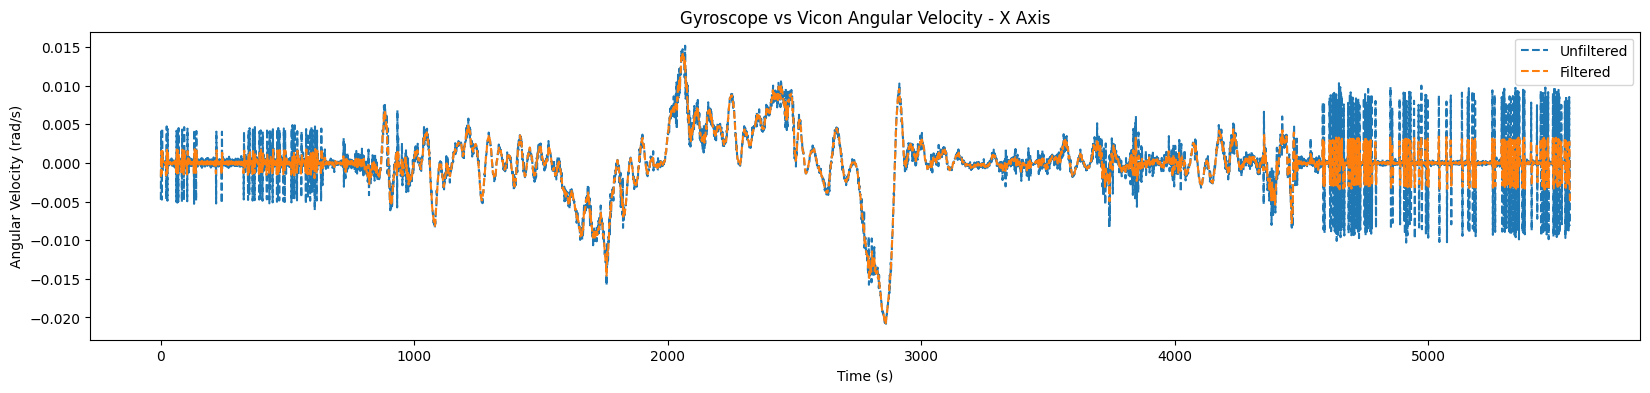

In [6]:
#filter/smooth vicon angular velocity
vicon_angular_velocity_filtered = np.zeros_like(vicon_angular_velocity)

window_size = 3
pad_width = window_size//2
padded_data = np.pad(vicon_angular_velocity, ((pad_width, pad_width), (0, 0)), mode='edge')

# Apply moving average filter
for i in range(len(vicon_angular_velocity)):
    vicon_angular_velocity_filtered[i] = np.mean(padded_data[i:i+window_size], axis=0)

plt.figure(figsize=(20, 4))
plt.plot(vicon_angular_velocity.T[1], label='Unfiltered', linestyle='--')
plt.plot(vicon_angular_velocity_filtered.T[1], label='Filtered', linestyle='--')
plt.title('Gyroscope vs Vicon Angular Velocity - X Axis')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()


In [7]:
#calculate bias while stationary
bias_gyro = np.mean(gyro[:,:10], axis=1)
print(bias_gyro)


sensitivity_gyro = np.sum(abs(gyro.T - bias_gyro)) * 3300/1023 * ((np.pi / 180) / np.sum(abs(vicon_angular_velocity_filtered)))
print(sensitivity_gyro)

gyro_adjusted = (gyro.T - bias_gyro)  * 3300/1023 * ((np.pi / 180) / sensitivity_gyro)

[373.6 375.2 369.8]
321.42265210121775


In [8]:
#create vicon or
vicon_orientation = []
for i in range(vicon_rotations.shape[2]):
    vicon_orientation.append(Quaternion().from_rotm(vicon_rotations[:,:,i]).euler_angles())
    
vicon_orientation = np.array(vicon_orientation)

gyro_orientation=[]
cur = Quaternion()  
for i in range(gyro_adjusted.T.shape[1]):
    q = Quaternion().from_axis_angle(gyro_adjusted[i])
    cur *= q
    gyro_orientation.append(cur.euler_angles())
    
gyro_orientation = np.array(gyro_orientation)

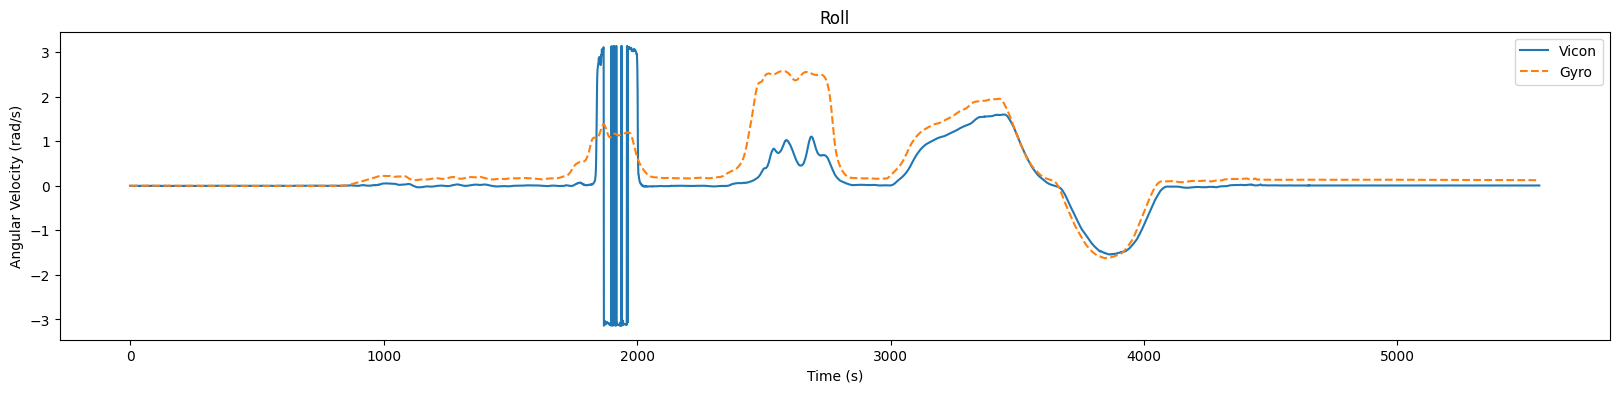

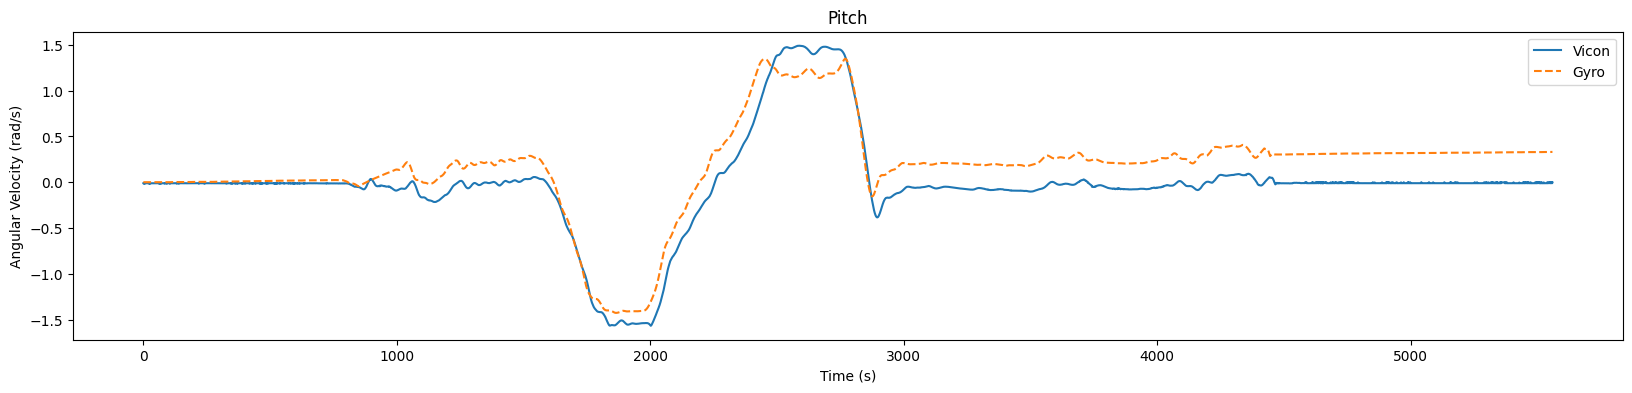

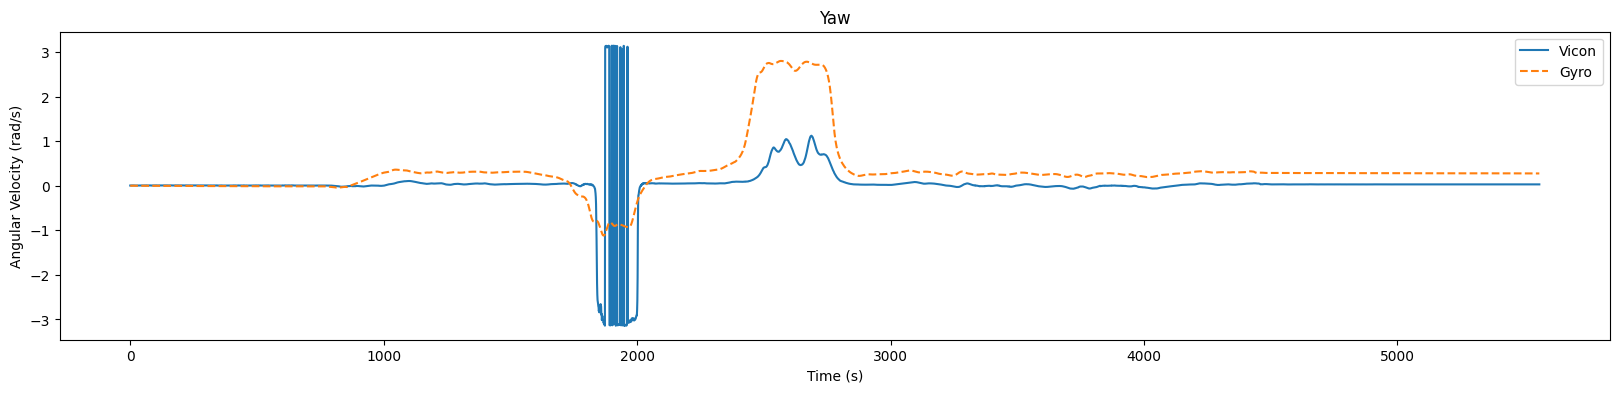

In [9]:
plt.figure(figsize=(20, 4))
plt.plot(vicon_orientation.T[0], label='Vicon', linestyle='-')
plt.plot(gyro_orientation.T[0], label='Gyro', linestyle='--')
plt.title('Roll')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(vicon_orientation.T[1], label='Vicon', linestyle='-')
plt.plot(gyro_orientation.T[1], label='Gyro', linestyle='--')
plt.title('Pitch')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()

plt.figure(figsize=(20, 4))
plt.plot(vicon_orientation.T[2], label='Vicon', linestyle='-')
plt.plot(gyro_orientation.T[2], label='Gyro', linestyle='--')
plt.title('Yaw')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.show()
